In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [2]:
mpl.rcParams['font.family'] = 'Times New Roman'
# 設置全局字體大小
mpl.rcParams['font.size'] = 14  # 全局字體大小

資料來源 : [歷年監測資料](https://airtw.moenv.gov.tw/CHT/Query/His_Data.aspx)

| 測站 | 測站 | 測站 | 測站 | 測站 |
| :--: | :--: | :--: | :--: | :--: |
| 二林 | 大里 | 竹山 | 西屯 | 沙鹿 |
| 忠明 | 南投 | 埔里 | 彰化 | 線西 |
| 豐原

In [3]:
# | 二林 | 大里 | 竹山 | 西屯 | 沙鹿 |
# | 忠明 | 南投 | 埔里 | 彰化 | 線西 |
# | 豐原

In [4]:
Year = 2021
Region_Name = '花東'
District_Name = '關山'

#### 刪除無效值

一般測站資料註記說明：# 表示儀器檢核為無效值，* 表示程式檢核為無效值，x 表示人工檢核為無效值，A 係指因儀器疑似故障警報所產生的無效值，空白 表示缺值。

### 無效值  
* 無效值  
X 無效值  
A 無效值  
缺值

In [6]:
# Specify the name of the CSV file to open
filename = f'C:\Users\User.DESKTOP-BAC597N\Desktop\關山_2021.csv'
#""
# Open the CSV file
df = pd.read_csv(filename).drop(columns=['Unnamed: 27'])
df

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (1959775385.py, line 2)

In [ ]:
df.replace(['#', '*', 'x', 'A'], np.nan, inplace=True)
# Check for missing values
directory = f'./../data_clean/{Region_Name}空品區_{Year}/{District_Name}'
if not os.path.exists(directory):
    os.makedirs(directory)

clean_data = df.to_csv(f'./../data_clean/{Region_Name}空品區_{Year}/{District_Name}/RawData_{District_Name}.csv', index=False)

NameError: name 'df' is not defined

##### 探討數值間相關性

In [ ]:
df_long = pd.melt(df, id_vars=['測站', '日期', '測項'], var_name='小時', value_name='數值')
df_long

NameError: name 'pd' is not defined

#### 進行遺漏值填補

總共偵測到的空氣微粒
<center>

| ElementCol_1 | ElementCol_2 | ElementCol_3 | ElementCol_4 | ElementCol_5 |
| :--: | :--: | :--: | :--: | :--: |
| AMB_TEMP | CH4 | CO | NMHC | NO |
| NO2 | NOx | O3 | PM10 | PM2.5 |
| RAINFALL | RH | SO2 | THC | WD_HR |
| WIND_DIREC | WIND_SPEED | WS_HR | 

</center>

In [ ]:
# 將日期列設為索引，並轉換為 datetime 格式
df['日期'] = pd.to_datetime(df['日期'])
df

NameError: name 'pd' is not defined

In [ ]:
# 將時間列轉換為列標籤
df = df.melt(id_vars=['測站','日期', '測項'], var_name='小時', value_name='數值')
df['小時'] = df['小時'].astype(int)

# 將日期和小時列合併為 datetime 格式
df['時間'] = df['日期'] + pd.to_timedelta(df['小時'], unit='h')


# 將時間列設為索引
df.set_index('時間', inplace=True)
df

NameError: name 'df' is not defined

In [ ]:
def fill_short_term_missing(df):
    # 確保 '數值' 列是數字類型
    df['數值'] = pd.to_numeric(df['數值'], errors='coerce')
    
    # 使用 groupby 以測站與測項來分組，並對每一組資料進行線性插值
    df['數值'] = df.groupby(['測站', '測項'], group_keys=False)['數值'].apply(
        lambda group: group.interpolate(method='linear', limit=24, limit_direction='both'))
    
    return df

In [ ]:
df = fill_short_term_missing(df)

NameError: name 'df' is not defined

In [ ]:
df.isna().sum()

NameError: name 'df' is not defined

In [ ]:
def fill_with_previous_next_one_day(df):
    
    # 確保 '數值' 列是數字類型
    df['數值'] = pd.to_numeric(df['數值'], errors='coerce')
    
    # 用來存儲需要補值的位置和計算後的值
    fill_values = {}

    # 逐個測站和測項進行處理
    for (station, item), group in df.groupby(['測站', '測項']):
        group = group.sort_index()
        
        # 依據日期進行分組，確定每天是否全部缺值
        daily_groups = group.groupby(group.index.date)
        
        for day, day_group in daily_groups:
            if day_group['數值'].isna().all():  # 如果整天都是缺值
                prev_day = pd.Timestamp(day) - pd.DateOffset(days=1)
                next_day = pd.Timestamp(day) + pd.DateOffset(days=1)
                
                prev_values = group.loc[prev_day.strftime('%Y-%m-%d')]['數值'] if prev_day in group.index.date else None
                next_values = group.loc[next_day.strftime('%Y-%m-%d')]['數值'] if next_day in group.index.date else None
                
                # 取前後兩天的平均值
                if prev_values is not None and next_values is not None:
                    filled_values = (prev_values + next_values) / 2
                    for idx in day_group.index:
                        fill_values[(idx, station, item)] = filled_values.mean()
    
    # 最後一次性將計算出的值補回到原 DataFrame，這裡用更精確的定位
    for (idx, station, item), value in fill_values.items():
        df.loc[(df.index == idx) & (df['測站'] == station) & (df['測項'] == item), '數值'] = value

    return df

In [ ]:
df = fill_with_previous_next_one_day(df)

NameError: name 'df' is not defined

In [ ]:
df.isna().sum()

NameError: name 'df' is not defined

In [ ]:
# 按照 '測項' 分組，並用每個分組的平均值填補空值
df['數值'] = df.groupby('測項')['數值'].transform(lambda x: x.fillna(x.mean()))

NameError: name 'df' is not defined

In [ ]:
df.isna().sum()

測站    0
日期    0
測項    0
小時    0
數值    0
dtype: int64

In [ ]:
df.to_csv(f'./../data_clean/{Region_Name}空品區_{Year}/{District_Name}/Filled_data_{District_Name}_RAW.csv', index=False)

In [ ]:
df.head()

,測站,日期,測項,小時,數值
時間,,,,,
2023-01-01,豐原,2023-01-01,AMB_TEMP,0,16.50
2023-01-01,豐原,2023-01-01,CH4,0,1.98
2023-01-01,豐原,2023-01-01,CO,0,0.32
2023-01-01,豐原,2023-01-01,NMHC,0,0.10
2023-01-01,豐原,2023-01-01,NO,0,1.40


In [ ]:
# 使用 pivot 將資料按照測項分類
df = df.pivot_table(index=['測站', '時間'], columns='測項', values='數值').reset_index()

# 檢視重排後的資料
print(df.head())
df.to_csv(f'./../data_clean/{Region_Name}空品區_{Year}/{District_Name}/Filled_data_{District_Name}.csv', index=False)

測項  測站                  時間  AMB_TEMP   CH4    CO  NMHC   NO  NO2  NOx  \
0   豐原 2023-01-01 00:00:00      16.5  1.98  0.32  0.10  1.4  8.0  9.4   
1   豐原 2023-01-01 01:00:00      16.4  1.99  0.34  0.09  0.8  7.9  8.7   
2   豐原 2023-01-01 02:00:00      16.1  2.00  0.32  0.06  0.6  8.3  8.9   
3   豐原 2023-01-01 03:00:00      16.2  2.00  0.34  0.08  0.6  7.8  8.4   
4   豐原 2023-01-01 04:00:00      16.4  2.03  0.35  0.12  0.8  7.4  8.2   

測項         O3  PM10  PM2.5  RAINFALL    RH  SO2   THC  WD_HR  WIND_DIREC  \
0   30.874182  44.0   34.0       0.0  88.0  1.4  2.08  289.0       283.0   
1    8.373171  31.0   24.0       0.0  89.0  0.8  2.08  227.0       299.0   
2   16.521951  17.0   10.0       0.0  91.0  0.7  2.06  299.0       301.0   
3   17.112195  20.0   20.0       0.0  94.0  0.7  2.08  109.0       149.0   
4   12.236585  19.0   23.0       0.0  94.0  0.6  2.15  280.0       220.0   

測項  WIND_SPEED  WS_HR  
0          0.8    0.3  
1          0.9    0.2  
2          0.6    0.3  
3       

In [ ]:
# # 提取數值變量
# df_features = df[['AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5', 
#                   'RAINFALL', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED', 'WS_HR']]
# correlation_matrix = df_features.corr()
# plt.figure(figsize=(12, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
# plt.title('Correlation Heatmap')
# plt.show()

In [ ]:
# # 提取與 PM2.5 的相關係數
# pm25_corr = correlation_matrix['PM2.5']


# # 過濾出大於 0.41 的相關係數（排除 PM2.5 自身）
# filtered_corr = pm25_corr[pm25_corr.abs() > 0.41].drop('PM2.5')
# filtered_corr = filtered_corr.sort_values(ascending=False)

# # 打印結果
# print("Variables with correlation greater than 0.41 with PM2.5:")
# for variable, corr_value in filtered_corr.items():
#     print(f"{variable}: {corr_value:.2f}")

In [ ]:
df

測項,測站,時間,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
0,豐原,2023-01-01 00:00:00,16.5,1.98,0.32,0.10,1.4,8.0,9.4,30.874182,44.0,34.0,0.0,88.0,1.4,2.08,289.0,283.0,0.8,0.3
1,豐原,2023-01-01 01:00:00,16.4,1.99,0.34,0.09,0.8,7.9,8.7,8.373171,31.0,24.0,0.0,89.0,0.8,2.08,227.0,299.0,0.9,0.2
2,豐原,2023-01-01 02:00:00,16.1,2.00,0.32,0.06,0.6,8.3,8.9,16.521951,17.0,10.0,0.0,91.0,0.7,2.06,299.0,301.0,0.6,0.3
3,豐原,2023-01-01 03:00:00,16.2,2.00,0.34,0.08,0.6,7.8,8.4,17.112195,20.0,20.0,0.0,94.0,0.7,2.08,109.0,149.0,0.6,0.3
4,豐原,2023-01-01 04:00:00,16.4,2.03,0.35,0.12,0.8,7.4,8.2,12.236585,19.0,23.0,0.0,94.0,0.6,2.15,280.0,220.0,0.7,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,豐原,2023-12-31 19:00:00,20.2,2.07,0.41,0.06,0.7,6.5,7.2,41.200000,42.0,36.0,0.0,73.0,2.4,2.13,4.0,352.0,2.0,1.4
8756,豐原,2023-12-31 20:00:00,19.2,2.09,0.46,0.07,0.8,5.6,6.4,41.600000,42.0,35.0,0.0,77.0,2.3,2.16,0.0,339.0,2.0,1.6
8757,豐原,2023-12-31 21:00:00,18.3,2.11,0.48,0.07,0.7,5.2,5.9,42.600000,47.0,40.0,0.0,79.0,2.8,2.18,344.0,356.0,2.1,1.5
8758,豐原,2023-12-31 22:00:00,18.3,2.10,0.46,0.07,0.9,4.3,5.2,41.500000,45.0,36.0,0.0,79.0,2.6,2.17,34.0,55.0,0.9,1.3


In [ ]:
print(f"Upper : {df['PM2.5'].mean() + 3 * df['PM2.5'].std()}")
print(f"Lower : {df['PM2.5'].mean() - 3 * df['PM2.5'].std()}")

Upper : 42.2228382147494
Lower : -11.562678397397804


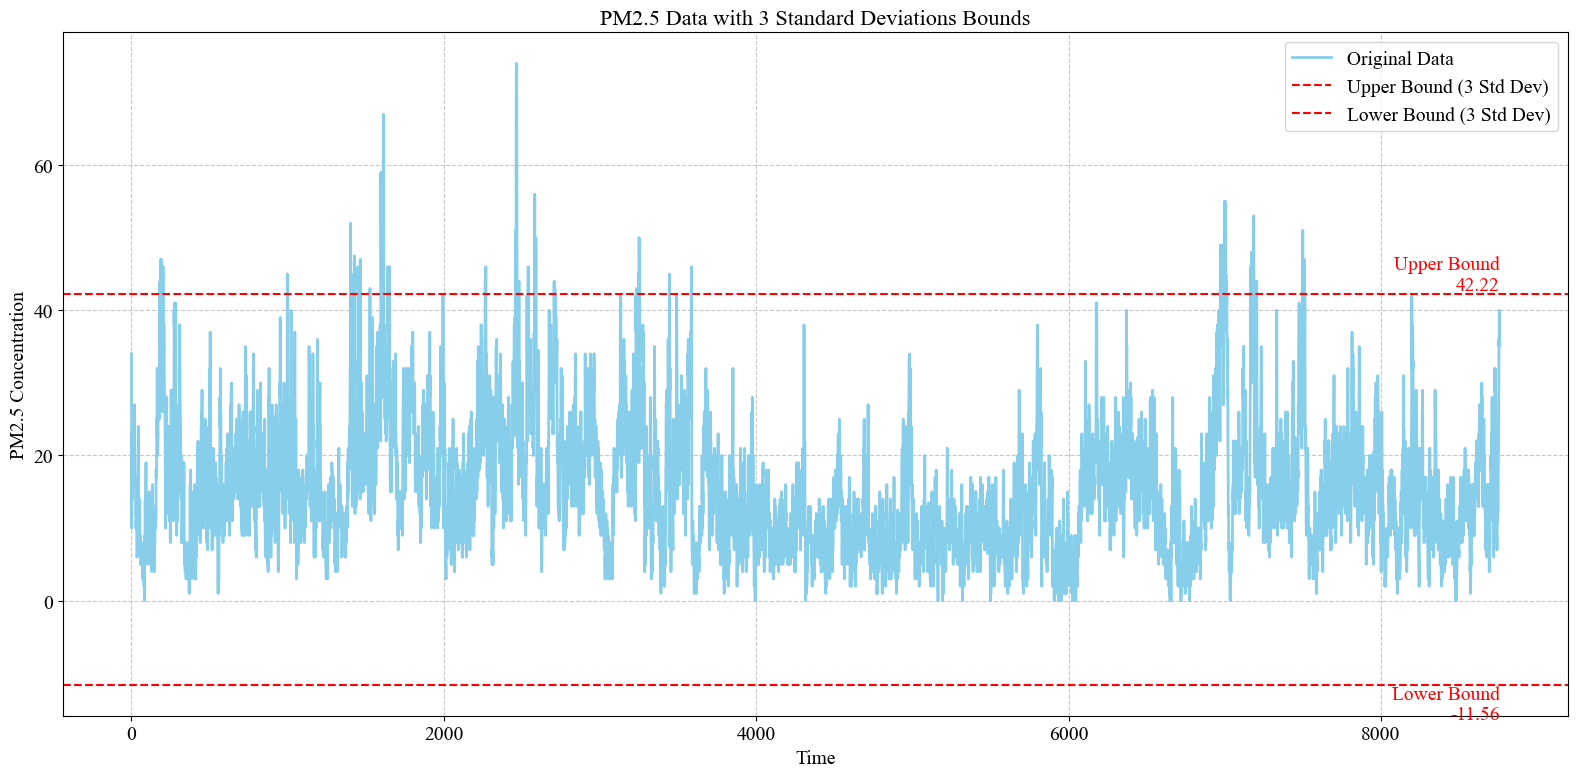

In [ ]:
import matplotlib.pyplot as plt

# 原始數據的均值和標準差
mean_pm25 = df['PM2.5'].mean()
std_pm25 = df['PM2.5'].std()

# 設定閾值（以三倍標準差為例）
threshold = 3
upper_bound = mean_pm25 + threshold * std_pm25
lower_bound = mean_pm25 - threshold * std_pm25

# Plot
plt.figure(figsize=(16, 8))
plt.plot(df['PM2.5'], label='Original Data', color='skyblue', linewidth=2)
plt.axhline(y=upper_bound, color='red', linestyle='--', linewidth=1.5, label='Upper Bound (3 Std Dev)')
plt.axhline(y=lower_bound, color='red', linestyle='--', linewidth=1.5, label='Lower Bound (3 Std Dev)')

# Add annotations
plt.text(df.index[-1], upper_bound, f'Upper Bound\n{upper_bound:.2f}', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.text(df.index[-1], lower_bound, f'Lower Bound\n{lower_bound:.2f}', color='red', verticalalignment='top', horizontalalignment='right')

# Set title and labels
plt.title('PM2.5 Data with 3 Standard Deviations Bounds', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('PM2.5 Concentration', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
def fill_outliers_with_previous_next_hour(df, column_name='PM2.5'):
    
    # Ensure the target column is numeric
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    
    # Dictionary to store positions that need filling and their computed values
    fill_values = {}

    # Process each station individually
    for station, group in df.groupby('測站'):
        group = group.sort_values('時間')  # Sort by '時間' column

        # Calculate the mean and standard deviation for the target column
        mean_value = group[column_name].mean()
        std_value = group[column_name].std()

        # Set the threshold for outliers
        threshold = 3
        outliers = (group[column_name] > mean_value + threshold * std_value) | (group[column_name] < mean_value - threshold * std_value)

        # Find the indices of the outliers
        outlier_indices = group.loc[outliers].index

        for idx in outlier_indices:
            prev_hour = group.loc[idx, '時間'] - pd.Timedelta(hours=1)
            next_hour = group.loc[idx, '時間'] + pd.Timedelta(hours=1)

            prev_value = group.loc[group['時間'] == prev_hour, column_name].values
            next_value = group.loc[group['時間'] == next_hour, column_name].values

            # Calculate the average of the previous and next hours
            if len(prev_value) > 0 and len(next_value) > 0:
                fill_value = (prev_value[0] + next_value[0]) / 2
                fill_values[(idx, station)] = fill_value
    
    # Update the original DataFrame with the computed values
    for (idx, station), value in fill_values.items():
        df.loc[idx, column_name] = value

    return df

In [ ]:
# Ensure '時間' column is in datetime format and set as the index
df['時間'] = pd.to_datetime(df['時間'])

In [ ]:
df = fill_outliers_with_previous_next_hour(df, 'PM2.5')
# 儲存處理後的數據
df.to_csv(f'./../data_clean/{Region_Name}空品區_{Year}/{District_Name}/Filled_data_{District_Name}_Final.csv', index=False)

In [ ]:
print(f"Upper : {df['PM2.5'].mean() + 3 * df['PM2.5'].std()}")
print(f"Lower : {df['PM2.5'].mean() - 3 * df['PM2.5'].std()}")

Upper : 41.62786153322694
Lower : -11.085300650426326


In [ ]:
df

測項,測站,時間,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
0,豐原,2023-01-01 00:00:00,16.5,1.98,0.32,0.10,1.4,8.0,9.4,30.874182,44.0,34.0,0.0,88.0,1.4,2.08,289.0,283.0,0.8,0.3
1,豐原,2023-01-01 01:00:00,16.4,1.99,0.34,0.09,0.8,7.9,8.7,8.373171,31.0,24.0,0.0,89.0,0.8,2.08,227.0,299.0,0.9,0.2
2,豐原,2023-01-01 02:00:00,16.1,2.00,0.32,0.06,0.6,8.3,8.9,16.521951,17.0,10.0,0.0,91.0,0.7,2.06,299.0,301.0,0.6,0.3
3,豐原,2023-01-01 03:00:00,16.2,2.00,0.34,0.08,0.6,7.8,8.4,17.112195,20.0,20.0,0.0,94.0,0.7,2.08,109.0,149.0,0.6,0.3
4,豐原,2023-01-01 04:00:00,16.4,2.03,0.35,0.12,0.8,7.4,8.2,12.236585,19.0,23.0,0.0,94.0,0.6,2.15,280.0,220.0,0.7,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,豐原,2023-12-31 19:00:00,20.2,2.07,0.41,0.06,0.7,6.5,7.2,41.200000,42.0,36.0,0.0,73.0,2.4,2.13,4.0,352.0,2.0,1.4
8756,豐原,2023-12-31 20:00:00,19.2,2.09,0.46,0.07,0.8,5.6,6.4,41.600000,42.0,35.0,0.0,77.0,2.3,2.16,0.0,339.0,2.0,1.6
8757,豐原,2023-12-31 21:00:00,18.3,2.11,0.48,0.07,0.7,5.2,5.9,42.600000,47.0,40.0,0.0,79.0,2.8,2.18,344.0,356.0,2.1,1.5
8758,豐原,2023-12-31 22:00:00,18.3,2.10,0.46,0.07,0.9,4.3,5.2,41.500000,45.0,36.0,0.0,79.0,2.6,2.17,34.0,55.0,0.9,1.3


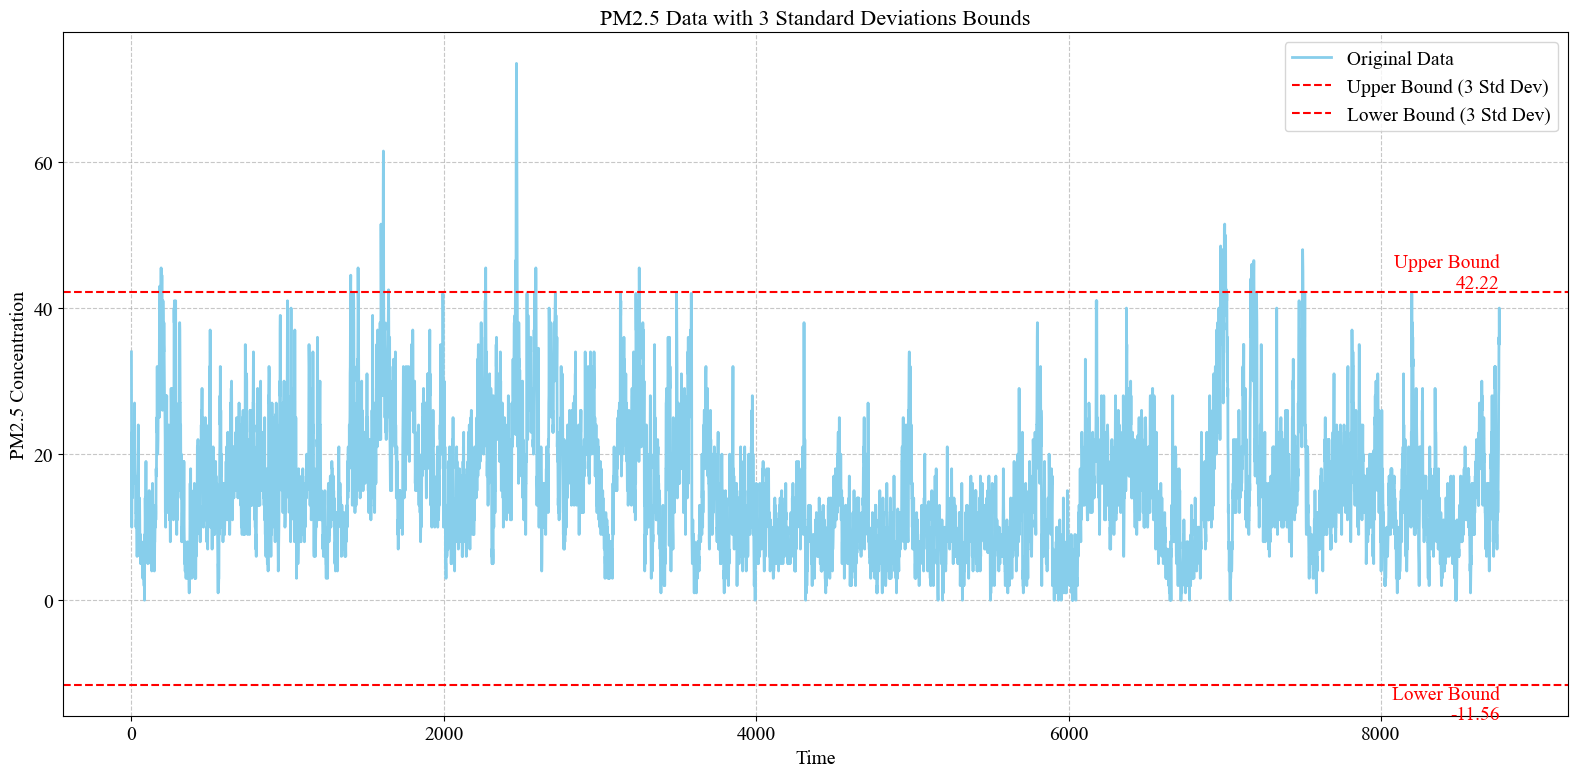

In [ ]:
# Plot
plt.figure(figsize=(16, 8))
plt.plot(df['PM2.5'], label='Original Data', color='skyblue', linewidth=2)
plt.axhline(y=upper_bound, color='red', linestyle='--', linewidth=1.5, label='Upper Bound (3 Std Dev)')
plt.axhline(y=lower_bound, color='red', linestyle='--', linewidth=1.5, label='Lower Bound (3 Std Dev)')

# Add annotations
plt.text(df.index[-1], upper_bound, f'Upper Bound\n{upper_bound:.2f}', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.text(df.index[-1], lower_bound, f'Lower Bound\n{lower_bound:.2f}', color='red', verticalalignment='top', horizontalalignment='right')

# Set title and labels
plt.title('PM2.5 Data with 3 Standard Deviations Bounds', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('PM2.5 Concentration', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()